In [1]:
import os
import random
from PIL import Image
import numpy as np

# Define the folder containing the image folders.
folder_path = "resized_adjusted_grayscale_text_regions"
# Define the patch size.
patch_size = (16, 16)
# Define the total number of patches you want to sample from each folder.
n = 100

# Initialize a list to store the patches.
patches = []


In [2]:
# Step 1: Loop through each folder and sample 'n' patches based on image sizes.
for folder_name in os.listdir(folder_path):
    folder = os.path.join(folder_path, folder_name)
    if os.path.isdir(folder):
        # Get a list of image files in the folder.
        image_files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(".png")]

        # Calculate the weight for each image based on its height x width pixel size.
        total_size = sum(Image.open(file).size[0] * Image.open(file).size[1] for file in image_files)
        image_weights = [Image.open(file).size[0] * Image.open(file).size[1] / total_size for file in image_files]

        # Distribute 'n' patches based on image weights within the folder.
        for _ in range(n):
            chosen_image = random.choices(image_files, weights=image_weights)[0]
            image = Image.open(chosen_image)
            width, height = image.size
            x = random.randint(0, width - patch_size[0])
            y = random.randint(0, height - patch_size[1])
            patch = image.crop((x, y, x + patch_size[0], y + patch_size[1]))

            # Flatten the patch and store it in the patches list.
            patch_array = np.array(patch).flatten()
            patches.append(patch_array)


patches = np.array(patches)

In [3]:
patches.shape

(5500, 256)

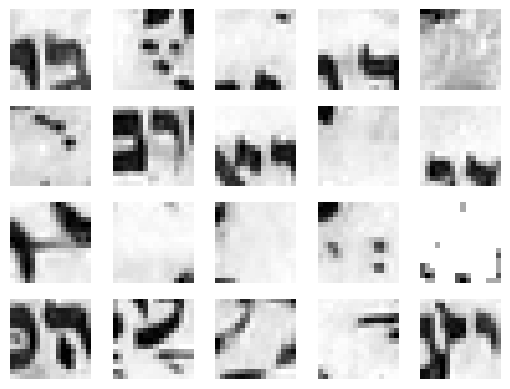

In [4]:
import matplotlib.pyplot as plt

# Select the first 20 patches
first_20_patches = patches[:20, :]

# Reshape the patches to their original dimensions (e.g., 16x16 for each patch)
patch_size = (16, 16)
num_patches = 20

for i in range(num_patches):
    patch = first_20_patches[i, :].reshape(*patch_size)  # Access the selected patches
    plt.subplot(4, 5, i + 1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')

plt.show()


In [5]:
def normalize_for_contrast(patches):
    # Calculate the mean and variance along axis 0 (rows) since you want to apply it to 'patches.T'
    patches_mean = np.mean(patches, axis=0, keepdims=True)
    patches_variance = np.var(patches, axis=0, ddof=1, keepdims=True)
    
    # Normalize for contrast
    normalized_patches = (patches - patches_mean) / np.sqrt(patches_variance + 10)
    
    return normalized_patches

# Assuming 'patches' is a 2D array where each column is a patch
normalized_patches = normalize_for_contrast(patches)



In [6]:
normalized_patches.shape

(5500, 256)

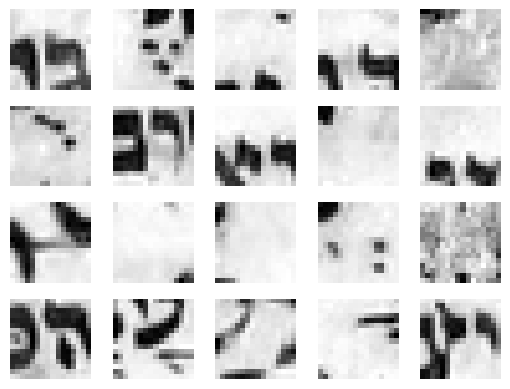

In [7]:
first_20_patches =normalized_patches[:20, :]

# Reshape the patches to their original dimensions (e.g., 16x16 for each patch)
patch_size = (16, 16)
num_patches = 20

for i in range(num_patches):
    patch = first_20_patches[i, :].reshape(*patch_size)  # Access the selected patches
    plt.subplot(4, 5, i + 1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')

plt.show()

In [8]:
def whiten_patches(patches):
    C = np.cov(patches, rowvar=False)
    M = np.mean(patches, axis=0)
    D, V = np.linalg.eigh(C)
    P = V @ np.diag(1 / np.sqrt(D + 0.1)) @ V.T
    whitened_patches = (patches - M) @ P
    return whitened_patches

# Whitening the normalized patches
whitened_normalized_patches = whiten_patches(normalized_patches)


In [9]:
whitened_normalized_patches.shape

(5500, 256)

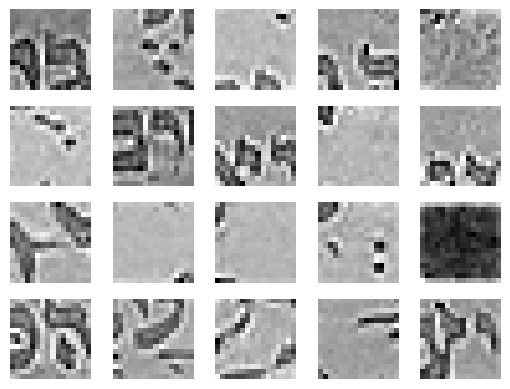

In [10]:
first_20_patches = whitened_normalized_patches[:20, :]

# Reshape the patches to their original dimensions (e.g., 16x16 for each patch)
patch_size = (16, 16)
num_patches = 20

for i in range(num_patches):
    patch = first_20_patches[i, :].reshape(*patch_size)  # Access the selected patches
    plt.subplot(4, 5, i + 1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')

plt.show()

In [26]:
from sklearn.cluster import KMeans

# Create a KMeans instance with 20 clusters
kmeans = KMeans(n_clusters=20)

# Fit the model to your data
clusters = kmeans.fit_predict(whitened_normalized_patches)



/home/nachum/berat/anaconda3/envs/midrashclusterenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


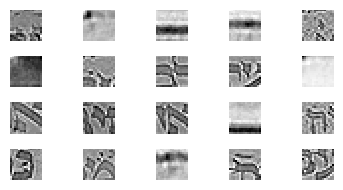

In [27]:
# Create a subplot for each centroid patch
plt.figure(figsize=(4, 2))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    centroid_patch = kmeans.cluster_centers_[i].reshape(16, 16)
    plt.imshow(centroid_patch, cmap='gray')
    plt.axis('off')

# Show the centroid patches
plt.tight_layout()
plt.show()




In [181]:
import cv2
import numpy as np

# Load your image
image_path = "resized_adjusted_grayscale_text_regions/16/16_region_2163_885_3160_3103.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Set the patch size and step size
patch_size = 16
step_size = 32  # You can set different values for x and y by changing this single variable

# Get the dimensions of the image
height, width = image.shape

# Calculate the number of steps in each direction
num_steps_x = (width - patch_size) // step_size + 1
num_steps_y = (height - patch_size) // step_size + 1

# Initialize arrays to store patches and coordinates
patches_array = []
coordinates_array = []

# Iterate through the image with the specified step size
for y_step in range(num_steps_y):
    for x_step in range(num_steps_x):
        # Calculate the starting coordinates
        y = y_step * step_size
        x = x_step * step_size

        # Extract the patch
        patch = image[y:y+patch_size, x:x+patch_size]

        # Add the patch and coordinates to arrays
        patches_array.append(patch.flatten())
        coordinates_array.append((x, y))

# Convert the lists to NumPy arrays
patches_array = np.array(patches_array, dtype=np.uint8)
coordinates_array = np.array(coordinates_array, dtype=np.uint16)




In [182]:
normalized_patches = normalize_for_contrast(patches_array)
whitened_normalized_patches = whiten_patches(normalized_patches)

In [183]:
# Predict the cluster assignments for the patches
patch_assignments = kmeans.predict(whitened_normalized_patches)

# Calculate the frequency of each patch cluster in the image
cluster_counts = np.bincount(patch_assignments, minlength=kmeans.n_clusters)

# Normalize the cluster counts to create a feature vector
feature_vector = cluster_counts / num_patches

# Find the most frequent dimension
most_frequent_dimension = np.argmax(feature_vector)

In [184]:
patches_assigned_to_dimension = np.where(kmeans.predict(whitened_normalized_patches) == most_frequent_dimension)[0]

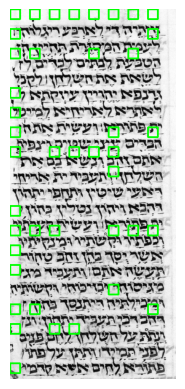

In [185]:
image_with_boxes = cv2.imread(image_path, 1)
for patch_index in patches_assigned_to_dimension:
    x, y = coordinates_array[patch_index]

    # Add a bounding box to the image
    cv2.rectangle(image_with_boxes, (x, y), (x + 16, y + 16), (0, 255, 0), 2)

plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()

In [191]:
import cv2
import numpy as np

# Load your image
image_path = "resized_adjusted_grayscale_text_regions/16/16_region_2163_885_3160_3103.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Set the patch size and number of patches
patch_size = 16
num_patches = 1000  # You can set the desired number of patches

# Get the dimensions of the image
height, width = image.shape

# Randomly sample patches with the specified number
patches_array = []
coordinates_array = []

for _ in range(num_patches):
    # Randomly sample starting coordinates
    y = np.random.randint(0, height - patch_size)
    x = np.random.randint(0, width - patch_size)

    # Extract the patch
    patch = image[y:y+patch_size, x:x+patch_size]

    # Add the patch and coordinates to arrays
    patches_array.append(patch.flatten())
    coordinates_array.append((x, y))

# Convert the lists to NumPy arrays
patches_array = np.array(patches_array, dtype=np.uint8)
coordinates_array = np.array(coordinates_array, dtype=np.uint16)



In [192]:
normalized_patches = normalize_for_contrast(patches_array)
whitened_normalized_patches = whiten_patches(normalized_patches)

In [193]:
# Predict the cluster assignments for the patches
patch_assignments = kmeans.predict(whitened_normalized_patches)

# Calculate the frequency of each patch cluster in the image
cluster_counts = np.bincount(patch_assignments, minlength=kmeans.n_clusters)

# Normalize the cluster counts to create a feature vector
feature_vector = cluster_counts / num_patches

# Find the most frequent dimension
most_frequent_dimension = np.argmax(feature_vector)

In [194]:
patches_assigned_to_dimension = np.where(kmeans.predict(whitened_normalized_patches) == most_frequent_dimension)[0]


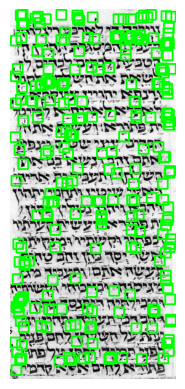

In [195]:
image_with_boxes = cv2.imread(image_path, 1)
for patch_index in patches_assigned_to_dimension:
    x, y = coordinates_array[patch_index]

    # Add a bounding box to the image
    cv2.rectangle(image_with_boxes, (x, y), (x + 16, y + 16), (0, 255, 0), 2)

plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()

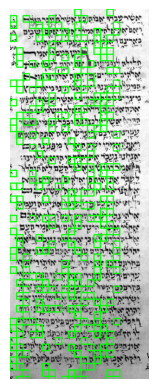

In [111]:
import cv2
import numpy as np
from skimage.util import view_as_windows
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to calculate feature vector
def calculate_feature_vector(image, kmeans_model, patch_size=(16, 16)):
    # Patchify the input image into non-overlapping patches
    patches = view_as_windows(image, patch_size)

    # Calculate the number of patches in the image
    num_patches = patches.shape[0] * patches.shape[1]

    # Reshape the patches into a 2D array (one row per patch)
    patches_2d = patches.reshape(num_patches, -1)

    # Predict the cluster assignments for the patches
    patch_assignments = kmeans_model.predict(patches_2d)

    # Calculate the frequency of each patch cluster in the image
    cluster_counts = np.bincount(patch_assignments, minlength=kmeans_model.n_clusters)

    # Normalize the cluster counts to create a feature vector
    feature_vector = cluster_counts / num_patches

    return feature_vector

# Function to find most frequent centroid and corresponding patches with coordinates
def find_most_frequent_centroid(image, kmeans_model, patch_size=(16, 16)):
    # Calculate the feature vector
    feature_vector = calculate_feature_vector(image, kmeans_model, patch_size)

    # Find the index of the most frequent centroid
    most_frequent_centroid = np.argmax(feature_vector)

    # Get indices of patches assigned to the most frequent centroid
    most_frequent_indices = np.where(kmeans_model.labels_ == most_frequent_centroid)[0]

    # Get patches assigned to the most frequent centroid
    patches = view_as_windows(image, patch_size)

    # Get coordinates of the patches in the original image
    patch_coordinates = []
    for index in most_frequent_indices:
        row, col = np.unravel_index(index, patches.shape[:2])
        patch_coordinates.append((row * patch_size[0], col * patch_size[1]))

    return patch_coordinates

# Read the image
image_path = "resized_adjusted_grayscale_text_regions/10/10_region_1112_384_1770_2135.png"
image = cv2.imread(image_path, 0)

# Find the most frequent centroid, corresponding patches, and patch coordinates
most_frequent_centroid, most_frequent_patches, patch_coordinates = find_most_frequent_centroid(image, kmeans)

# Draw bounding boxes around all patches assigned to the most frequent centroid
image_with_boxes = cv2.imread(image_path, 1)
for patch, (x, y) in zip(most_frequent_patches, patch_coordinates):
    h, w = patch_size
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with bounding boxes using Matplotlib
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()


In [ ]:
import os
import numpy as np
from skimage import io
from skimage.util import view_as_windows
from sklearn.cluster import KMeans

# Create a list to store feature vectors
feature_vectors = []

# Load and preprocess document images
image_directory = 'resized_adjusted_grayscale_text_regions'

for folder_name in os.listdir(image_directory):
    folder_path = os.path.join(image_directory, folder_name)
    if os.path.isdir(folder_path):
        for image_filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_filename)
            image = io.imread(image_path)
            # Extract feature vector based on the cluster assignments of patches
            feature_vector = calculate_feature_vector(image, kmeans)  # Implement this function
            feature_vectors.append(feature_vector)

# Convert feature_vectors to a NumPy array
feature_matrix = np.array(feature_vectors)

# Apply K-means clustering to document images
kmeans_documents = KMeans(n_clusters=5)
document_clusters = kmeans_documents.fit_predict(feature_matrix)

# Create a dictionary to store image file names and their clusters
image_clusters = {}

# Load and preprocess document images again to associate them with clusters
for cluster_id, folder_name in zip(document_clusters, os.listdir(image_directory)):
    folder_path = os.path.join(image_directory, folder_name)
    if os.path.isdir(folder_path):
        for image_filename in os.listdir(folder_path):
            # Store the image file name and its cluster in the dictionary
            image_clusters[image_filename] = cluster_id




In [ ]:
import os
import shutil

# Create a directory to store the cluster images
output_directory = 'cluster_visualization'
os.makedirs(output_directory, exist_ok=True)

# Load the mapping information from the "mapping.txt" file into a dictionary
mapping = {}
with open('mapping.txt', 'r') as mapping_file:
    for line in mapping_file:
        parts = line.strip().split(' -> ')
        if len(parts) == 2:
            origin_name, sequential_name = parts
            origin_name = os.path.splitext(origin_name)[0]
            sequential_name = os.path.splitext(sequential_name)[0]
            mapping[sequential_name.strip()] = origin_name.strip()

# Iterate through each image and its cluster assignment
for image_filename, cluster_id in image_clusters.items():
    folder_name = image_filename.split('_')[0]
    original_name = mapping.get(folder_name)

    folder_path = os.path.join(image_directory, folder_name)
    image_path = os.path.join(folder_path, image_filename)
    
    # Define the cluster-specific folder
    cluster_folder = os.path.join(output_directory, f'Cluster_{cluster_id}')
    os.makedirs(cluster_folder, exist_ok=True)

    # Copy the image to the cluster-specific folder with the modified name
    modified_image_name = f'{original_name}__{image_filename}'
    modified_image_path = os.path.join(cluster_folder, modified_image_name)
    shutil.copy(image_path, modified_image_path)
